# Compute global mean ocean SSH from ECCO Version 4 Release 4

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45569")
client

<Client: 'tcp://127.0.0.1:45569' processes=8 threads=32, memory=58.74 GiB>

In [56]:
import pandas as pd
import sys
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

import matplotlib.pyplot as plt
import json
import time

from dask.distributed import get_worker
from dask import delayed

from pprint import pprint
import requests
import s3fs
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from itertools import repeat
from os.path import expanduser, basename, isfile, isdir, join

## subroutines to compute global mean sea level and trends

In [5]:
def compute_GMSL(SSH, grid_area, total_grid_cell_area):
    GMSL = (SSH * grid_area).sum(dim=['latitude','longitude']) / total_grid_cell_area
    GMSL = GMSL.compute()
    return GMSL

In [6]:
def compute_GMSL_trend(GMSL):
    # fit a line
    trend_params = GMSL.polyfit(dim="time", deg=1, full=True)
    GMSL_trend = xr.polyval(coord=GMSL.time, coeffs=trend_params.polyfit_coefficients)

    return GMSL_trend, trend_params

## subroutines to download files from S3 to the local machine

In [7]:
def download(source, target, redownload_existing=False):
    
    print(target)
    print(source)
    if not os.path.isfile(target) or redownload_existing==True:
        !wget --quiet --continue --output-document $target $source
    else:
        print('not re-downloading')
    return target

In [8]:
def download_file(url: str, out: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    out (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(out):
        raise Exception(f"Output directory doesnt exist! ({out})")
    
    target_file = join(out, basename(url))
    
    # if the file has already been downloaded, skip    
    if isfile(target_file) and force is False:
        print('file exists, and force=False, not re-downloading')
        return 0
    
    with requests.get(url) as r:
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

In [9]:
# download a list of files
def download_files(dls):
    start_time = time.time()

    # use 12 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=12) as executor:
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir)), total=len(dls)))
    
        total_download_size_in_bytes = np.sum(np.array(results))
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

## Define local disk directories

In [10]:
# output directory
output_dir=Path('//home/jpluser/ifenty/ECCO_global_mean_TS')
output_dir.mkdir(exist_ok=True)

ECCO_grid_dir =Path('/home/jpluser/ifenty/ECCO_grids/')
ECCO_grid_dir.mkdir(exist_ok=True)

# staging directory
download_dir=Path('/home/jpluser/ifenty/ECCO_global_mean_TS/tmp_dl')
download_dir.mkdir(exist_ok=True)

## Connect S3 file system

get keys, pass credentials

In [11]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())

    creds ={}
    creds['AccessKeyId'] = accessKeyId
    creds['SecretAccessKey'] = secretAccessKey
    creds['SessionToken'] = sessionToken
    creds['expiration'] = expiration
    
    return creds



In [12]:
def refresh_s3():
    creds = store_aws_keys()
    s3 = s3fs.S3FileSystem(
        key=creds['AccessKeyId'],
        secret=creds['SecretAccessKey'],
        token=creds['SessionToken'],
        client_kwargs={'region_name':'us-west-2'},
    )
    print(f"\nThe current session token expires at {creds['expiration']}.\n")
    return s3


## Download ECCO grid geometry to local disk

In [13]:
ECCO_grid_filename = 'GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc'
ECCO_grid_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/"

source = ECCO_grid_url + ECCO_grid_filename
target = ECCO_grid_dir / ECCO_grid_filename

local_grid_fname = download(source, target)
ecco_grid = xr.open_dataset(local_grid_fname)
ecco_grid.load()
print(ecco_grid.data_vars)

/home/jpluser/ifenty/ECCO_grids/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc
https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc
not re-downloading
Data variables:
    hFacC    (Z, latitude, longitude) float64 nan nan nan nan ... nan nan nan
    Depth    (latitude, longitude) float64 nan nan nan ... 4.178e+03 4.178e+03
    area     (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    drF      (Z) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    maskC    (Z, latitude, longitude) bool False False False ... False False


## Calculate ECCO grid cell volumes and total ocean volume


In [14]:
# area is grid cell area * land/ocean mask
# volume is grid cell thickness (drF) * area (rA) * partial cell factors (hFacC) * land/ocean mask (maskC)

grid_cell_area = ecco_grid.area * ecco_grid.maskC.isel(Z=0)
grid_cell_vol = ecco_grid.drF * ecco_grid.area * ecco_grid.hFacC * ecco_grid.maskC

total_grid_cell_area= grid_cell_area.sum()
total_grid_cell_area.name = 'Total ECCO ocean area'

total_grid_cell_vol = grid_cell_vol.sum()
total_grid_cell_vol.name = 'Total ECCO ocean volume'

print(f'total grid cell area  {total_grid_cell_area.values/1e9:0.3g} billion km^2')
print(f'total grid cell volume  {total_grid_cell_vol.values/1e9:0.3g} billion km^3')

total grid cell area  3.58e+05 billion km^2
total grid cell volume  1.34e+09 billion km^3


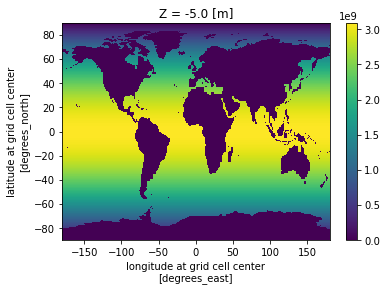

In [15]:
grid_cell_area.plot()

## Find S3 Addresses to ECCO Fields

In [16]:
# PO.DAAC's 'short name' is an identifier for the dataset
ShortName = 'ECCO_L4_SSH_05DEG_MONTHLY_V4R4'

In [17]:
# Ask PODAAC for the collection id using the 'short name'
response = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': ShortName,
            'page_size': 1}
)

ummc = response.json()['items'][0]
ccid = ummc['meta']['concept-id']
print(f'collection id: {ccid}')

collection id: C1990404799-POCLOUD


In [19]:
# glob to find the NetCDF files associated with this collection id
year = '*'

start_time = time.time()

ss = "podaac-ops-cumulus-protected/" + ShortName + '/*'+ str(year) + '*.nc'

s3 = refresh_s3()
ECCO_s3_files = s3.glob(ss)

print(f'time to find urls: { time.time() - start_time} s\n')

# make a list of just the filenames
ECCO_files =[]
for f in ECCO_s3_files:
    ECCO_files.append(f.split('/')[-1])

pprint(ECCO_files[0])
pprint(ECCO_files[-1])
pprint(ECCO_s3_files[0])
pprint(ECCO_s3_files[-1])


The current session token expires at 2022-07-06 02:15:41+00:00.

time to find urls: 7.42154598236084 s

'SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc'
'SEA_SURFACE_HEIGHT_mon_mean_2017-12_ECCO_V4r4_latlon_0p50deg.nc'
'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_latlon_0p50deg.nc'
'podaac-ops-cumulus-protected/ECCO_L4_SSH_05DEG_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2017-12_ECCO_V4r4_latlon_0p50deg.nc'


In [20]:
# convert list of s3 files to urls
ECCO_s3_files_as_http = ['https://archive.podaac.earthdata.nasa.gov/' + f for f in ECCO_s3_files]

# First Approach: Calculate using S3 Direct Access fields

In [21]:
download_files(ECCO_s3_files_as_http)

file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloadingfile exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading

file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloadingfile exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading

file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and force=False, not re-downloading
file exists, and for

100%|████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 251416.49it/s]

file exists, and force=False, not re-downloading

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


### Access files using Method 1: Direct File Access, parallel=True

In [47]:
start_time = time.time()
local_files = np.sort(list(download_dir.glob('*nc')))

num_granules = 312
ECCO_SSH_ds = xr.open_mfdataset(
    paths=local_files[:num_granules],
    coords='minimal', 
    compat='override', 
    data_vars='minimal',
    decode_cf=True,
    join='left',
    parallel = True
)
ECCO_SSH_ds.close()

tt = time.time() - start_time

print(f'open time = {tt:0.3g} s')
print(f'open time per granule (n={num_granules}) = {tt/num_granules:0.3g} s \n') 

open time = 3.1 s
open time per granule (n=312) = 0.00993 s 



In [36]:
%%time 
GMSL = compute_GMSL(ECCO_SSH_ds.SSH, ecco_grid.area, total_grid_cell_area)
GMSL_trend, trend_params = compute_GMSL_trend(GMSL)

CPU times: user 738 ms, sys: 41.7 ms, total: 780 ms
Wall time: 2.31 s


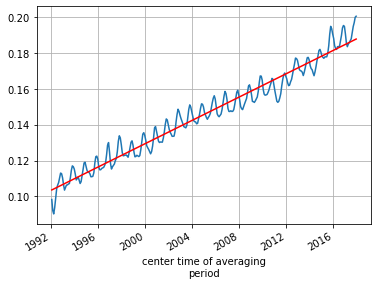

In [38]:
GMSL.plot()
GMSL_trend.plot(color='r')
plt.grid()

In [39]:
# rough trend: final - initial / length of time series in years
GMSL_rough_trend = 1000*(GMSL_trend[-1]-GMSL_trend[0])/(len(GMSL.time)/12)
print(f'{np.round(GMSL_rough_trend.values,3)} mm/yr')

3.231 mm/yr


# Method 2: Direct S3 Access, parallel=False

parallel must be false else open_mfdataset hangs

In [48]:
## read num_granules number of files
num_granules = 32

# update s3 credentials
s3 = refresh_s3()

# open each file using s3
paths=[s3.open(f) for f in ECCO_s3_files[:num_granules]]

start_time = time.time()

ECCO_SSH_ds = xr.open_mfdataset(
    paths=paths,
    coords='minimal', 
    compat='override', 
    data_vars='minimal',
    decode_cf=True,
    join='left',
    parallel=False
)
ECCO_SSH_ds.close()

tt = time.time() - start_time

print(f'open time = {tt:0.3g} s')
print(f'open time per granule (n={num_granules}) = {tt/num_granules:0.3g} s \n') 

## WITH ATTACHED DASK CLUSTER AND PARALLEL=FALSE
#===============================================
# 3 files  0.4 s (.14 s per)
# 12 files 1.7 (.14s per)
# 24 files 3.6 (0.15s per)
# 36 files 5.4 (0.15s per)
# ...
# 312 files 54 s (0.18s per)


The current session token expires at 2022-07-06 02:22:10+00:00.

open time = 6.18 s
open time per granule (n=32) = 0.193 s 



In [49]:
# verify we got something good 
pprint(ECCO_SSH_ds.data_vars)
pprint(ECCO_SSH_ds.dims)

Data variables:
    SSH       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC    (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC  (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Frozen({'time': 32, 'latitude': 360, 'longitude': 720, 'nv': 2})


In [50]:
%%time 
GMSL = compute_GMSL(ECCO_SSH_ds['SSH'], ecco_grid.area, total_grid_cell_area)
GMSL_trend, GMSL_params = compute_GMSL_trend(GMSL)

CPU times: user 137 ms, sys: 37.5 ms, total: 174 ms
Wall time: 475 ms


rough trend = 5.316 mm/yr


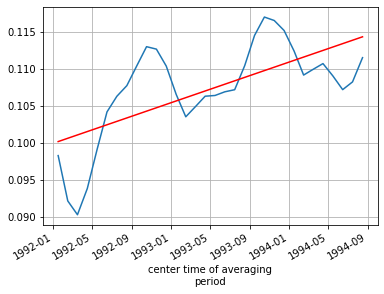

In [51]:
GMSL.plot()
GMSL_trend.plot(color='r')
plt.grid()

# rough trend: (final - initial) / length of time series in years
GMSL_rough_trend = 1000*(GMSL_trend[-1]-GMSL_trend[0])/(len(GMSL.time)/12)
print(f'rough trend = {np.round(GMSL_rough_trend.values,3)} mm/yr')

# Method 3: Direct S3 Access, parallel=True

In [45]:
## READ THIS MANY FILES
num_granules = 12

# update s3 credentials
s3 = refresh_s3()

# open each file using s3
paths=[s3.open(f) for f in ECCO_s3_files[:num_granules]]

start_time = time.time()

# if the files in 'paths' were LOCAL this does work,
# when the files are on S3, crashes with error message:

#ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
#https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
#https://docs.xarray.dev/en/stable/user-guide/io.html

ECCO_SSH_ds = xr.open_mfdataset(
    paths=paths,
    coords='minimal', 
    compat='override', 
    data_vars='minimal',
    decode_cf=True,
    join='left',
    parallel=True
)
ECCO_SSH_ds.close()

tt = time.time() - start_time

print(f'open time = {tt:0.3g} s')
print(f'open time per granule (n={num_granules}) = {tt/num_granules:0.3g} s \n') 

## WITH ATTACHED DASK CLUSTER AND PARALLEL=TRUE
#===============================================
# 3 files  0.4 s (.14 s per)
# 12 files 1.7 (.14s per)
# 24 files 3.6 (0.15s per)
# 36 files 5.4 (0.15s per)
# ...
# 312 files 54 s (0.18s per)


The current session token expires at 2022-07-06 02:20:37+00:00.



ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

# Method 4: Delayed mode

In [57]:
def delayed_global_mean(fn, s3, ecco_grid_area, total_grid_cell_area):
    
    d_start_time = time.time()
    
# works when we open with open_dataset, dask client, and files on S3
    ECCO_SSH_ds = xr.open_dataset(s3.open(fn))    

# fails with open_mfdataset, dask client, and files on S3
#    ECCO_SSH_ds = xr.open_mfdataset(s3.open(fn))
        
    GMSL = compute_GMSL(ECCO_SSH_ds['SSH'], ecco_grid_area, total_grid_cell_area)
    worker_id = get_worker().id
    
    if worker_id == 'Worker-5fdf7c84-8fd8-47cf-be05-e3c295b5726f':
        tt = time.time() - d_start_time
    else :
        tt = -1
    return GMSL, tt

In [60]:
ecco_grid_area= ecco_grid.area
from dask import delayed,compute


In [64]:
start_time = time.time()

num_granules = 312
result=[]

for fn in ECCO_s3_files[0:num_granules]:
    result.append(delayed(delayed_global_mean)(fn, s3, \
                                               ecco_grid_area, total_grid_cell_area) )

tt = time.time() - start_time

print('append result')
print(f'append result time = {tt:0.3g} s')
 
print('calculate')

GMSL_delayed =np.array(compute(result)).squeeze()
tt = time.time() - start_time

print(f'calc time = {tt:0.3g} s')
print(f'calc time per granule (n={num_granules}) = {tt/num_granules:0.3g} s \n') 


# calculation timing
# ==================
#  64:  2.7s, 0.0416s per granule
# 128:  5.6s, 0.0432s per granule
# 312: 13  s, 0.0416s per granule

append result
append result time = 0.0656 s
calculate
calc time = 13.1 s
calc time per granule (n=312) = 0.042 s 

